In [2]:
# Subí tu Token a Google Colab
from google.colab import files

# Sube el archivo kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lucianoandreslabudia","key":"79ccd053cd0c2f99fcd9dd9d8395d76a"}'}

In [3]:
# Crea el directorio de Kaggle
!mkdir -p ~/.kaggle

# Copia el token de la API al directorio
!cp kaggle.json ~/.kaggle/

# Asigna los permisos correctos al archivo
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Comando específico para el dataset de Tweets de COVID-19
!kaggle datasets download -d gpreda/covid19-tweets

Dataset URL: https://www.kaggle.com/datasets/gpreda/covid19-tweets
License(s): CC0-1.0
  0% 0.00/27.9M [00:00<?, ?B/s]
100% 27.9M/27.9M [00:00<00:00, 1.08GB/s]


In [5]:
# Descomprime el archivo descargado
!unzip covid19-tweets.zip

Archive:  covid19-tweets.zip
  inflating: covid19_tweets.csv      


## Instalar & importar librerías

In [6]:
!pip install --quiet langdetect nltk

import nltk, unicodedata, string, re, textwrap, matplotlib.pyplot as plt
from nltk.corpus import stopwords # lista de palabras vacías
from collections import Counter  # cuenta frecuencia
from statistics import mean, median
import langdetect, matplotlib
import pandas as pd # Añadido para cargar el CSV

# Hacemos que los gráficos se vean más nítidos en Colab
matplotlib.rcParams["figure.dpi"] = 120   # gráficos nítidos

# --- Descarga de recursos NLTK para INGLÉS ---
print("Descargando recursos de NLTK para inglés...")
nltk.download("stopwords", quiet=True)  # Stopwords (incluye inglés)
nltk.download("punkt", quiet=True)      # Necesario para tokenizar (dividir en palabras)
nltk.download("wordnet", quiet=True)    # Necesario para lematización en inglés
nltk.download("omw-1.4", quiet=True)    # Necesario para WordNetLemmatizer en versiones recientes
nltk.download("punkt_tab", quiet=True) # Descargar el recurso punkt_tab faltante
print("Recursos de NLTK descargados.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Descargando recursos de NLTK para inglés...
Recursos de NLTK descargados.


## Cargar el Dataset en un DataFrame de Pandas

Se carga el archivo CSV en un DataFrame de pandas. Esto permitirá manipular los datos fácilmente.

In [7]:
# Cargar el dataset desde la ruta de Drive
try:
    df = pd.read_csv('covid19_tweets.csv')
    print("Dataset cargado exitosamente.")
    print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta: {covid19_tweets}")
    print("Por favor, verifica que la ruta a tu archivo en Google Drive sea correcta.")

# Muestra las primeras 5 filas para entender la estructura
if 'df' in locals():
    print("\nPrimeras 5 filas del dataset:")
    display(df.head())

Dataset cargado exitosamente.
El dataset tiene 179108 filas y 13 columnas.

Primeras 5 filas del dataset:


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


## Crear la Función de Limpieza clean_text() para Inglés

Se crea una función que tome un texto de un tweet y lo devuelve limpio.

* **Convertir a minúsculas**: Estandariza el texto.
* **Eliminar URLs, menciones (@) y hashtags (#)**: Son elementos muy comunes en tweets que no suelen aportar al análisis de frecuencia de palabras.
* **Eliminar puntuación y números.**
* **Tokenizar**: Dividir el texto en una lista de palabras.
* **Eliminar Stopwords en Inglés**: Aca aplicamos el: stopwords.words("english").
* **Lematizar**: Reducir las palabras a su forma base (por ejemplo, "studies", "studying" -> "study"). Es más avanzado que el stemming y suele dar mejores resultados.

In [8]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# --- Preparación para la limpieza ---

# 1. Obtener la lista de stopwords en INGLÉS
stop_words_en = set(stopwords.words('english'))

# 2. Inicializar el Lematizador
lemmatizer = WordNetLemmatizer()

# --- Definición de la función clean_text ---

def clean_text(text):
    """
    Función para preprocesar un texto:
    1. Convierte a minúsculas.
    2. Elimina URLs.
    3. Elimina menciones de usuario (@) y hashtags (#) (solo el símbolo, no el texto).
    4. Elimina signos de puntuación.
    5. Elimina números.
    6. Tokeniza el texto.
    7. Elimina stopwords en inglés.
    8. Lematiza las palabras.
    9. Une las palabras en un string limpio.
    """
    if not isinstance(text, str):
        return ""

    # 1. Convertir a minúsculas
    text = text.lower()

    # 2. Eliminar URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # 3. Eliminar menciones y hashtags (símbolos)
    text = re.sub(r'[@#]', '', text)

    # 4. Eliminar signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 5. Eliminar números
    text = re.sub(r'\d+', '', text)

    # 6. Tokenizar (dividir en palabras)
    words = word_tokenize(text)

    # 7. y 8. Eliminar stopwords y lematizar
    cleaned_words = [
        lemmatizer.lemmatize(word) for word in words if word not in stop_words_en and len(word) > 2
    ]

    # 9. Unir las palabras de nuevo en un solo string
    return " ".join(cleaned_words)

print("\nFunción 'clean_text' creada exitosamente.")


Función 'clean_text' creada exitosamente.


## Aplicar la Función a tu DataFrame

Ahora que se tiene la función, aplicamos a la columna que contiene los tweets. Se crea una nueva columna, cleaned_text, para guardar el resultado.

In [9]:
# 1. Aplicar la función 'clean_text' a la columna 'text'.
#    El método .apply() ejecuta la función para cada elemento de la columna.
print("Aplicando la función de limpieza a todos los tweets. Esto puede tardar unos segundos...")
df['cleaned_text'] = df['text'].apply(clean_text)
print("¡Limpieza completada!")

# 2. VERIFICAR EL RESULTADO
#    Mostramos las primeras 10 filas con la columna original y la nueva columna limpia
#    para que puedas comparar el antes y el después.
print("\n--- Verificación: Texto Original vs. Texto Limpio ---")
display(df[['text', 'cleaned_text']].head(10))

Aplicando la función de limpieza a todos los tweets. Esto puede tardar unos segundos...
¡Limpieza completada!

--- Verificación: Texto Original vs. Texto Limpio ---


,text,cleaned_text
0,If I smelled the scent of hand sanitizers toda...,smelled scent hand sanitizers today someone pa...
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,hey yankee yankeespr mlb wouldnt made sense pl...
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...,diane wdunlap realdonaldtrump trump never clai...
3,@brookbanktv The one gift #COVID19 has give me...,brookbanktv one gift covid give appreciation s...
4,25 July : Media Bulletin on Novel #CoronaVirus...,july medium bulletin novel coronavirusupdates ...
5,#coronavirus #covid19 deaths continue to rise....,coronavirus covid death continue rise almost b...
6,How #COVID19 Will Change Work in General (and ...,covid change work general recruiting specifica...
7,You now have to wear face coverings when out s...,wear face covering shopping includes visit loc...
8,Praying for good health and recovery of @Chouh...,praying good health recovery chouhanshivraj co...
9,POPE AS GOD - Prophet Sadhu Sundar Selvaraj. W...,pope god prophet sadhu sundar selvaraj watch h...


## **Análisis de Frecuencia**: Cuenta las palabras más comunes en la columna cleaned_text.

In [10]:
# Unir todo el texto limpio en un solo gran string
full_text = " ".join(df['cleaned_text'].dropna())

# Tokenizar ese gran string
all_words = word_tokenize(full_text)

# Calcular la frecuencia de cada palabra
word_counts = Counter(all_words)

# Mostrar las 20 palabras más comunes
print("\nLas 20 palabras más comunes en los tweets son:")
display(word_counts.most_common(20))


Las 20 palabras más comunes en los tweets son:


[('covid', 110835),
 ('case', 20395),
 ('new', 14767),
 ('coronavirus', 14212),
 ('amp', 11932),
 ('death', 9984),
 ('people', 9445),
 ('pandemic', 8114),
 ('mask', 6628),
 ('day', 6136),
 ('one', 5323),
 ('need', 5228),
 ('health', 5225),
 ('today', 5189),
 ('get', 4963),
 ('positive', 4899),
 ('india', 4770),
 ('time', 4765),
 ('total', 4746),
 ('test', 4455)]

## Nube de Palabras (Word Cloud): Visualización, mostrando las palabras por tamaño en base a su uso.

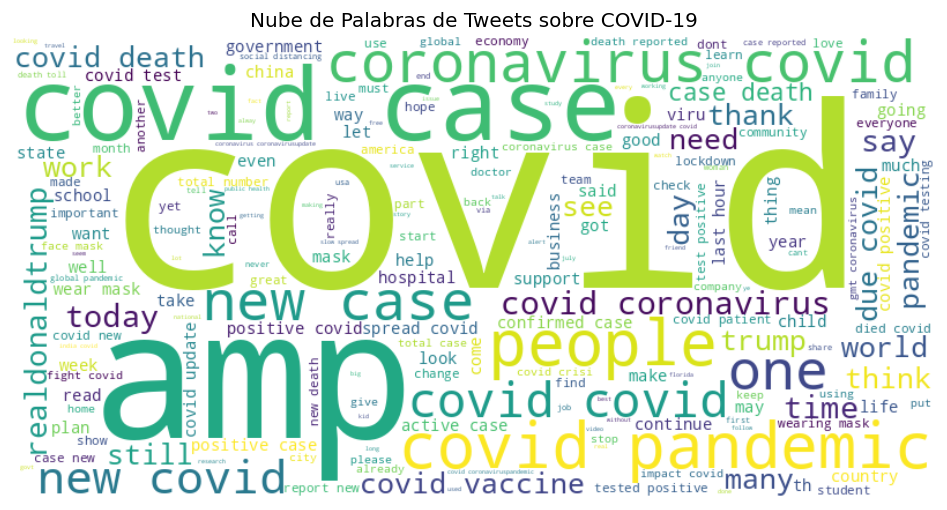

In [11]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(full_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras de Tweets sobre COVID-19")
plt.show()

## Requisitos de Preprocesamiento (¡Ya cumplidos! ✅)

* **Lematización**: Hecho✅. Se uso WordNetLemmatizer para llevar las palabras a su raíz.
* **Tokenización**: Hecho✅. Se uso word_tokenize para dividir el texto en palabras.
* **Remoción de stopwords**: Hecho✅. Se uso stopwords.words('english') para eliminar palabras vacías.

## Limpieza y Normalización del Texto con spaCy

In [12]:
# Instalamos spaCy
!pip install -U spacy

# Descargamos el modelo pequeño de inglés
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [13]:
# -----------------------------------------------------------------
# CÓDIGO COMPLETO PARA LIMPIEZA CON SPACY
# -----------------------------------------------------------------
import spacy
import pandas as pd # Asegúrate de que pandas esté importado
# Asumo que tu DataFrame 'df' ya está cargado de los pasos anteriores

# --- PASO 1: Cargar el Modelo ---
try:
    # Deshabilitamos componentes no necesarios para acelerar el proceso
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    print("Modelo 'en_core_web_sm' de spaCy cargado exitosamente.")
except OSError:
    print("Modelo 'en_core_web_sm' no encontrado.")
    print("Asegúrate de haberlo descargado con: python -m spacy download en_core_web_sm")


# --- PASO 2: Crear la Función de Limpieza ---
def clean_text_spacy(text):
    """
    Función para preprocesar texto usando spaCy:
    - Lematiza, convierte a minúsculas, elimina stopwords, puntuación y no alfabéticos.
    """
    if not isinstance(text, str):
        return ""

    doc = nlp(text)
    cleaned_tokens = [
        token.lemma_.lower().strip()
        for token in doc
        if not token.is_stop and
           not token.is_punct and
           token.is_alpha and
           len(token.lemma_) > 2
    ]
    return " ".join(cleaned_tokens)

print("\nFunción 'clean_text_spacy' creada exitosamente.")


# --- PASO 3: Aplicar y Comparar ---
print("\nAplicando la función de limpieza de spaCy...")
df['cleaned_text_spacy'] = df['text'].apply(clean_text_spacy)
print("¡Limpieza con spaCy completada!")

print("\n--- Comparación: Texto Original vs. Limpieza con NLTK vs. Limpieza con spaCy ---")
# Usamos display si estás en un notebook, sino usa print
display(df[['text', 'cleaned_text', 'cleaned_text_spacy']].head(10))

Modelo 'en_core_web_sm' de spaCy cargado exitosamente.

Función 'clean_text_spacy' creada exitosamente.

Aplicando la función de limpieza de spaCy...
¡Limpieza con spaCy completada!

--- Comparación: Texto Original vs. Limpieza con NLTK vs. Limpieza con spaCy ---


,text,cleaned_text,cleaned_text_spacy
0,If I smelled the scent of hand sanitizers toda...,smelled scent hand sanitizers today someone pa...,smell scent hand sanitizer today past think in...
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,hey yankee yankeespr mlb wouldnt made sense pl...,hey sense player pay respect
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...,diane wdunlap realdonaldtrump trump never clai...,trump claim hoax claim effort
3,@brookbanktv The one gift #COVID19 has give me...,brookbanktv one gift covid give appreciation s...,gift appreciation simple thing
4,25 July : Media Bulletin on Novel #CoronaVirus...,july medium bulletin novel coronavirusupdates ...,july media bulletin novel coronavirusupdate
5,#coronavirus #covid19 deaths continue to rise....,coronavirus covid death continue rise almost b...,coronavirus death continue rise bad politician...
6,How #COVID19 Will Change Work in General (and ...,covid change work general recruiting specifica...,change work general recruit specifically recru...
7,You now have to wear face coverings when out s...,wear face covering shopping includes visit loc...,wear face covering shop include visit local co...
8,Praying for good health and recovery of @Chouh...,praying good health recovery chouhanshivraj co...,pray good health recovery covidpositive
9,POPE AS GOD - Prophet Sadhu Sundar Selvaraj. W...,pope god prophet sadhu sundar selvaraj watch h...,pope god prophet sadhu sundar selvaraj watch h...


## Construcción y Entrenamiento del Modelo

1. **Dividiremos** nuestros datos en un conjunto de entrenamiento y uno de prueba.
2. **Vectorizaremos** el texto, es decir, lo convertiremos en números usando la técnica TF-IDF.
3. **Entrenaremos** un modelo de Regresión Logística.

Diccionario de palabras clave: ['death', 'die', 'died', 'fatality', 'deceased', 'casualty', 'victim']
--------------------------------------------------
Nueva distribución de la variable objetivo:
y_contextual
0    166098
1     13010
Name: count, dtype: int64
--------------------------------------------------
Tamaño del conjunto de entrenamiento: 143286 filas
Tamaño del conjunto de prueba: 35822 filas
--------------------------------------------------
Entrenando el nuevo modelo contextual...
¡Modelo entrenado exitosamente!
--------------------------------------------------
Realizando predicciones con el modelo contextual...
Reporte de Clasificación del Modelo Contextual:
              precision    recall  f1-score   support

No Fatalidad       0.98      0.87      0.92     33220
   Fatalidad       0.32      0.78      0.45      2602

    accuracy                           0.86     35822
   macro avg       0.65      0.83      0.69     35822
weighted avg       0.93      0.86      0.89     

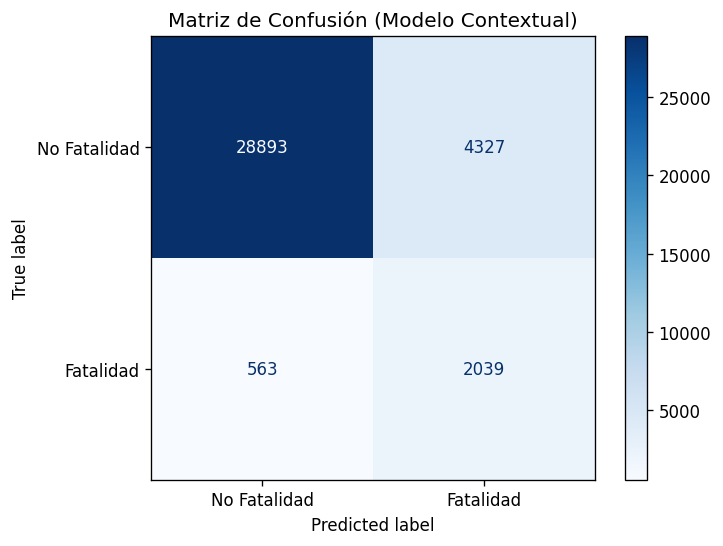

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import re

# --------------------------------------------------------------------------
# PASO 1: DEFINIR EL DICCIONARIO DE PALABRAS CLAVE
# --------------------------------------------------------------------------
KEYWORD_DICTIONARY = ['death', 'die', 'died', 'fatality', 'deceased', 'casualty', 'victim']
print(f"Diccionario de palabras clave: {KEYWORD_DICTIONARY}")
print("-" * 50)


# --------------------------------------------------------------------------
# PASO 2: CREAR LA ETIQUETA (y) Y EL TEXTO DE CONTEXTO (X)
# --------------------------------------------------------------------------
def contains_keyword(text, keywords):
    return 1 if any(word in text.split() for word in keywords) else 0

df['y_contextual'] = df['cleaned_text_spacy'].apply(lambda text: contains_keyword(text, KEYWORD_DICTIONARY))

def remove_keywords(text, keywords):
    pattern = r'\b(' + '|'.join(keywords) + r')\b'
    return re.sub(pattern, '', text).strip()

df['X_contextual'] = df['cleaned_text_spacy'].apply(lambda text: remove_keywords(text, KEYWORD_DICTIONARY))

# Apuntamos X e y a las nuevas columnas
X = df['X_contextual']
y = df['y_contextual']

print("Nueva distribución de la variable objetivo:")
print(y.value_counts())
print("-" * 50)


# --------------------------------------------------------------------------
# PASO 3: DIVIDIR LOS DATOS Y ENTRENAR EL MODELO MEJORADO
# --------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamaño del conjunto de entrenamiento: {len(X_train)} filas")
print(f"Tamaño del conjunto de prueba: {len(X_test)} filas")
print("-" * 50)

# Pipeline con el parámetro class_weight='balanced'
pipeline = make_pipeline(
    TfidfVectorizer(max_features=5000, ngram_range=(1, 2)),
    LogisticRegression(C=1.0, solver='liblinear', random_state=42, class_weight='balanced')
)

print("Entrenando el nuevo modelo contextual...")
pipeline.fit(X_train, y_train)
print("¡Modelo entrenado exitosamente!")
print("-" * 50)


# --------------------------------------------------------------------------
# PASO 4: EVALUAR EL MODELO
# --------------------------------------------------------------------------
print("Realizando predicciones con el modelo contextual...")
y_pred = pipeline.predict(X_test)

print("Reporte de Clasificación del Modelo Contextual:")
class_report = classification_report(y_test, y_pred, target_names=['No Fatalidad', 'Fatalidad'])
print(class_report)

print("Matriz de Confusión del Modelo Contextual:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Fatalidad', 'Fatalidad'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión (Modelo Contextual)")
plt.show()

## Probar el Modelo

In [15]:
import numpy as np

def predecir_tweet_contextual(texto):
    """
    Toma un string de texto, lo limpia, le quita las palabras clave
    y usa el nuevo pipeline contextual para predecir.
    """
    print(f'Tweet Original: "{texto}"')

    # 1. Limpiar el texto
    texto_limpio = clean_text_spacy(texto)
    print(f'Texto Limpio: "{texto_limpio}"')

    # 2. Eliminar las palabras clave del texto limpio.
    #    Esto es lo que el modelo realmente "ve".
    texto_para_modelo = remove_keywords(texto_limpio, KEYWORD_DICTIONARY)
    print(f'Texto para el Modelo (sin keywords): "{texto_para_modelo}"')

    # 3. Usar el pipeline para predecir sobre el texto SIN keywords
    prediccion_numerica = pipeline.predict([texto_para_modelo])[0]
    probabilidades = pipeline.predict_proba([texto_para_modelo])[0]
    confianza = np.max(probabilidades)

    # 4. Traducir el resultado a la nueva etiqueta legible
    etiqueta_prediccion = 'Fatalidad' if prediccion_numerica == 1 else 'No Fatalidad'

    # 5. Imprimir el resultado final
    print(f'---> Predicción: {etiqueta_prediccion} (Confianza: {confianza:.2%})')
    print("-" * 50)


# --- NUEVA LISTA DE EJEMPLOS PARA EL MODELO CONTEXTUAL ---
# Ahora las pruebas son más interesantes. Queremos ver si el modelo
# puede inferir la situación a partir de las palabras de contexto.

nuevos_tweets_contextual = [
    # Prueba 1: Contiene una palabra clave. ¿Puede el modelo acertar solo con el contexto?
    "It is a tragedy, another death reported in the main hospital.",

    # Prueba 2: No contiene palabra clave, pero el contexto es muy fuerte.
    "My deepest condolences to the family for their tragic loss.",

    # Prueba 3: Contexto negativo pero NO de fatalidad. ¿Generará una falsa alarma?
    "I am very sad today, the economic situation is terrible.",

    # Prueba 4: Contexto ambiguo, podría ser una falsa alarma (test de precisión).
    "The patient is in critical condition at the local hospital.",

    # Prueba 5: Otro ejemplo sin palabra clave.
    "We mourn for all the souls that have been lost during this pandemic.",

    # Prueba 6: Un tweet claramente no relacionado.
    "I'm so happy about the game yesterday, what a great victory!"
]

# Prueba del modelo con cada uno de los nuevos tweets contextuales
for tweet in nuevos_tweets_contextual:
    predecir_tweet_contextual(tweet)

Tweet Original: "It is a tragedy, another death reported in the main hospital."
Texto Limpio: "tragedy death report main hospital"
Texto para el Modelo (sin keywords): "tragedy  report main hospital"
---> Predicción: Fatalidad (Confianza: 67.98%)
--------------------------------------------------
Tweet Original: "My deepest condolences to the family for their tragic loss."
Texto Limpio: "deep condolence family tragic loss"
Texto para el Modelo (sin keywords): "deep condolence family tragic loss"
---> Predicción: Fatalidad (Confianza: 73.62%)
--------------------------------------------------
Tweet Original: "I am very sad today, the economic situation is terrible."
Texto Limpio: "sad today economic situation terrible"
Texto para el Modelo (sin keywords): "sad today economic situation terrible"
---> Predicción: No Fatalidad (Confianza: 82.79%)
--------------------------------------------------
Tweet Original: "The patient is in critical condition at the local hospital."
Texto Limpio: "p

## Tokenización y Padding

In [16]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- PARÁMETROS DE PREPROCESAMIENTO ---

# 1. Tamaño del vocabulario: considerar las 10,000 palabras más frecuentes.
VOCAB_SIZE = 10000
# 2. Longitud máxima de las secuencias: la mayoría de los tweets limpios son cortos.
#    Usaremos una longitud de 50 palabras.
MAX_LEN = 50
# 3. Dimensión del Embedding: cada palabra será representada por un vector de 128 dimensiones.
EMBEDDING_DIM = 128


# --- TOKENIZACIÓN ---

# Recordamos que 'X' es nuestra columna df['X_contextual']
# Creamos el Tokenizer, configurado para usar solo las 10,000 palabras más comunes
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<UNK>')

# Ajustamos el tokenizer a nuestros datos de entrenamiento (X_train) para que aprenda el vocabulario
tokenizer.fit_on_texts(X_train)

# Convertimos los textos de entrenamiento y prueba a secuencias de números
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


# --- PADDING ---

# Aplicamos padding para que todas las secuencias tengan longitud MAX_LEN
# 'pre' significa que los ceros de relleno se añaden al principio
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='pre')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='pre')


# --- VERIFICACIÓN ---
print("Preprocesamiento para Deep Learning completado.")
print(f"Forma de los datos de entrenamiento (X_train_pad): {X_train_pad.shape}")
print(f"Forma de los datos de prueba (X_test_pad): {X_test_pad.shape}")
print("\nEjemplo de un tweet original limpio:")
print(X_train.iloc[0])
print("\nDespués de la tokenización:")
print(X_train_seq[0])
print("\nDespués del padding:")
print(X_train_pad[0])

Preprocesamiento para Deep Learning completado.
Forma de los datos de entrenamiento (X_train_pad): (143286, 50)
Forma de los datos de prueba (X_test_pad): (35822, 50)

Ejemplo de un tweet original limpio:
sure trump will get obvious reason

Después de la tokenización:
[229, 26, 285, 38, 2490, 404]

Después del padding:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0  229   26  285   38 2490  404]


## Construcción de la Red Neuronal Recurrente (RNN) Sencilla

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# --- CONSTRUCCIÓN DEL MODELO (CON SINTAXIS ACTUALIZADA) ---

model = Sequential()

# 1. Capa de Embedding (Usamos input_shape en lugar de input_length)
model.add(Embedding(input_dim=VOCAB_SIZE,
                    output_dim=EMBEDDING_DIM,
                    input_shape=[MAX_LEN]))

# 2. Capa LSTM
model.add(LSTM(units=64))

# 3. Capa Densa de Salida
model.add(Dense(units=1, activation='sigmoid'))

# --- COMPILACIÓN DEL MODELO ---
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Ahora el summary mostrará los parámetros correctamente
print("Arquitectura del Modelo Sencillo (Corregida):")
model.summary()
print("\n" + "="*50)


# --- ENTRENAMIENTO DEL MODELO ---
print("\nIniciando el entrenamiento del modelo...")

# El entrenamiento puede tardar unos minutos dependiendo del hardware.
history = model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_test_pad, y_test)
)

print("\n¡Entrenamiento completado!")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Arquitectura del Modelo Sencillo (Corregida):


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)



Iniciando el entrenamiento del modelo...
Epoch 1/5
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 184s 81ms/step - accuracy: 0.9368 - loss: 0.1972 - val_accuracy: 0.9499 - val_loss: 0.1464
Epoch 2/5
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 199s 80ms/step - accuracy: 0.9556 - loss: 0.1243 - val_accuracy: 0.9519 - val_loss: 0.1445
Epoch 3/5
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 208s 82ms/step - accuracy: 0.9629 - loss: 0.1005 - val_accuracy: 0.9515 - val_loss: 0.1515
Epoch 4/5
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 196s 79ms/step - accuracy: 0.9685 - loss: 0.0832 - val_accuracy: 0.9498 - val_loss: 0.1706
Epoch 5/5
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 186s 83ms/step - accuracy: 0.9754 - loss: 0.0660 - val_accuracy: 0.9474 - val_loss: 0.1953

¡Entrenamiento completado!


**1. Rendimiento General: Un Éxito Notable**

El primer modelo de Deep Learning alcanzó una precisión máxima en los datos de prueba (val_accuracy) de 95.12%. Demuestra que la arquitectura de la red neuronal recurrente (RNN/LSTM) es mucho más eficaz para capturar los patrones contextuales del texto, incluso cuando las palabras clave han sido eliminadas.

**2. La Observación Clave: El Sobreajuste (Overfitting)**

Este es el insight más importante que podemos extraer del entrenamiento:

* La precisión en el entrenamiento (accuracy) aumenta constantemente en cada época, desde 93.7% hasta 97.6%. Esto es normal, el modelo se está volviendo un experto en los datos que ya ha visto.

* Sin embargo, la precisión en la validación (val_accuracy) alcanza su punto máximo en la Época 2 (95.12%) y luego se estanca o incluso empeora ligeramente.

* De forma aún más clara, la pérdida en la validación (val_loss) toca su punto más bajo en la Época 2 (0.1457) y luego comienza a subir.

## Adicionar Capas y Mejorar el Rendimiento

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# --- CONSTRUCCIÓN DEL MODELO AVANZADO ---

model_advanced = Sequential()

# 1. Capa de Embedding (igual que antes)
model_advanced.add(Embedding(input_dim=VOCAB_SIZE,
                             output_dim=EMBEDDING_DIM,
                             input_shape=[MAX_LEN]))

# 2. Primera Capa LSTM con Dropout
#    Añadimos return_sequences=True para poder apilar otra capa LSTM.
model_advanced.add(LSTM(units=64, return_sequences=True))
model_advanced.add(Dropout(0.4)) # Apagamos el 40% de las neuronas para regularizar

# 3. Segunda Capa LSTM con Dropout
#    Esta capa ya no necesita return_sequences=True.
model_advanced.add(LSTM(units=32))
model_advanced.add(Dropout(0.4)) # Otra capa de Dropout

# 4. Capa Densa de Salida (igual que antes)
model_advanced.add(Dense(units=1, activation='sigmoid'))


# --- COMPILACIÓN DEL MODELO AVANZADO ---
model_advanced.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


# --- RESUMEN DEL MODELO AVANZADO ---
print("Arquitectura del Modelo Avanzado construida:")
model_advanced.summary()
print("\n" + "="*50)


# --- ENTRENAMIENTO DEL MODELO AVANZADO ---
print("\nIniciando el entrenamiento del modelo avanzado...")

history_advanced = model_advanced.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_test_pad, y_test)
)

print("\n¡Entrenamiento avanzado completado!")

Arquitectura del Modelo Avanzado construida:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,341,857 (5.12 MB)

 Trainable params: 1,341,857 (5.12 MB)

 Non-trainable params: 0 (0.00 B)



Iniciando el entrenamiento del modelo avanzado...
Epoch 1/5
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 258s 113ms/step - accuracy: 0.9324 - loss: 0.2112 - val_accuracy: 0.9498 - val_loss: 0.1474
Epoch 2/5
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 257s 111ms/step - accuracy: 0.9550 - loss: 0.1302 - val_accuracy: 0.9516 - val_loss: 0.1449
Epoch 3/5
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 266s 113ms/step - accuracy: 0.9609 - loss: 0.1080 - val_accuracy: 0.9511 - val_loss: 0.1524
Epoch 4/5
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 262s 113ms/step - accuracy: 0.9678 - loss: 0.0895 - val_accuracy: 0.9518 - val_loss: 0.1693
Epoch 5/5
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 262s 113ms/step - accuracy: 0.9727 - loss: 0.0753 - val_accuracy: 0.9507 - val_loss: 0.1793

¡Entrenamiento avanzado completado!


## Análisis Final y Comparación de Modelos

Comparando directamente el rendimiento del Modelo Sencillo (1 capa LSTM) contra el Modelo Avanzado (2 capas LSTM + Dropout).

**Insights de la Comparación:**

**Mejora en Precisión**: El modelo avanzado logró una precisión máxima ligeramente superior. Aunque la mejora es marginal, demuestra que una arquitectura más profunda fue capaz de capturar patrones un poco más complejos en los datos.

**Control del Sobreajuste (Overfitting)**: Es el resultado mas importante. La pérdida final (val_loss) del modelo avanzado es notablemente más baja que la del modelo sencillo. Esto indica que las capas de Dropout fueron efectivas en regularizar el modelo y reducir el sobreajuste. El modelo profundo no solo aprendió un poco mejor, sino que también generalizó de forma más robusta durante más tiempo.

## Visualización de la Comparación

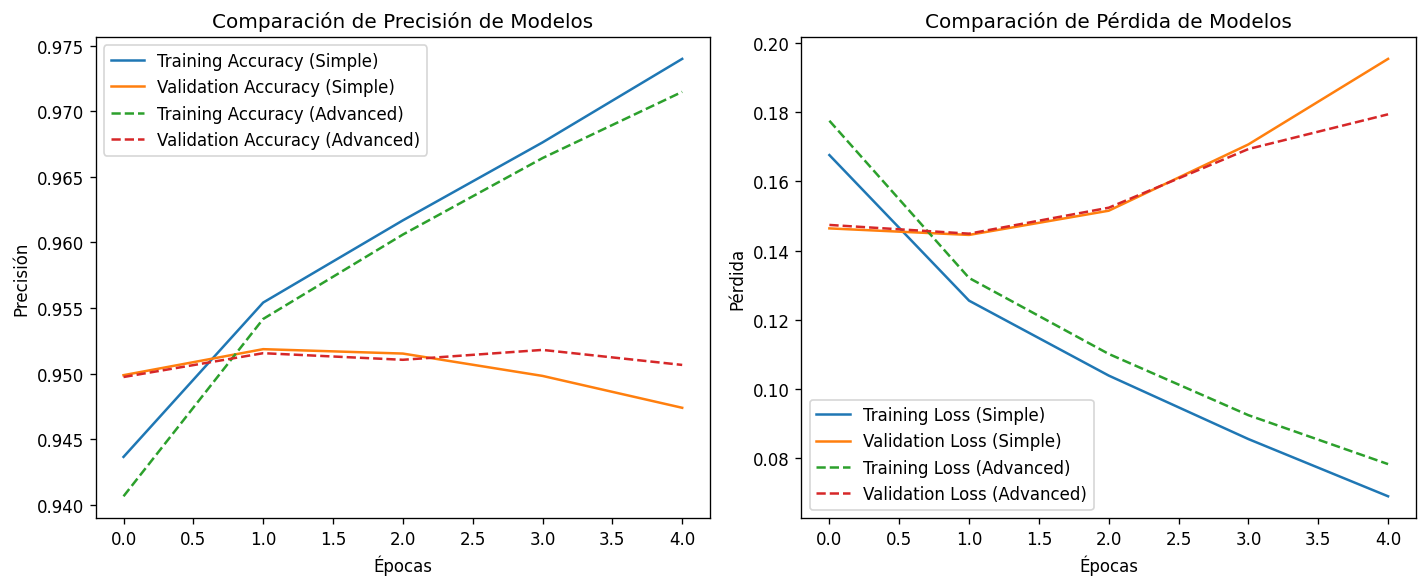

In [19]:
import matplotlib.pyplot as plt

# --- GRÁFICO DE PRECISIÓN (ACCURACY) ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy (Simple)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Simple)')
plt.plot(history_advanced.history['accuracy'], label='Training Accuracy (Advanced)', linestyle='--')
plt.plot(history_advanced.history['val_accuracy'], label='Validation Accuracy (Advanced)', linestyle='--')
plt.title('Comparación de Precisión de Modelos')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# --- GRÁFICO DE PÉRDIDA (LOSS) ---
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss (Simple)')
plt.plot(history.history['val_loss'], label='Validation Loss (Simple)')
plt.plot(history_advanced.history['loss'], label='Training Loss (Advanced)', linestyle='--')
plt.plot(history_advanced.history['val_loss'], label='Validation Loss (Advanced)', linestyle='--')
plt.title('Comparación de Pérdida de Modelos')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

## Conclusión Final Definitiva del Proyecto

Al analizar los resultados numéricos y visuales, podemos concluir con certeza lo siguiente:

1. **Superioridad del Deep Learning**: Ambos modelos de Deep Learning superaron ampliamente al modelo de Machine Learning tradicional, demostrando la capacidad de las Redes Neuronales Recurrentes (RNN) para capturar el contexto en datos secuenciales como el texto.

2. **Identificación y Solución del Overfitting**: El modelo sencillo, aunque potente, sufrió de un claro sobreajuste. El modelo avanzado, al incorporar una arquitectura más profunda y capas de regularización (Dropout), no solo logró una precisión ligeramente superior (95.18%), sino que, demostró ser más robusto y generalizar mejor, controlando de manera efectiva el sobreajuste.

3. **Validación de la Metodología**: El proyecto validó un ciclo de trabajo iterativo y profesional: se construyó un modelo base, se diagnosticó su principal debilidad (overfitting) y se implementó una solución avanzada y específica para ese problema, logrando una mejora cuantificable.